# **CS410: Natural Language Processing, Fall 2023**
## *Historical Effect on Efficacy in GPT Lineage in Text Summarization Task*
### by Dan Jang, Kobe Norcross, & Ahmad Alyajouri - 11/30/2023

1. To execute the program locally, first make sure you have updated your pip to the latest setting:
    
        pip install --upgrade pip

2. Install TensorFlow with pip. For GPU users:
        
        pip install tensorflow[and-cuda]
    
    For CPU users:
    
        pip install tensorflow

3. Install libraries as listed from **Part 1a**: *Initialization: Libraries & Initial Input Text Generation using GPT-2 model [124M]

### **Content Warning**: *Alike many "natural language processing" oriented or sources for text & data, the text & data used in this project may have been collected from public websites or sources, and may be unfiltered. Thus, some text & data may be disturbing, disagreeable, or otherwise objectionable.*

### **Part 1a**: *Initialization: Libraries & Initial Input Text Generation using GPT-2 model [124M]*

The [*GPT-2* model](https://github.com/openai/gpt-2/) was loaded using the [*GPT2LMHeadModel*](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel/) & [*GPT2Tokenizer*](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer) methods from the [*transformers*](https://huggingface.co/docs/transformers/) library.

The specific version used is the smallest version of the [*GPT-2* model](https://huggingface.co/gpt2/), with *124 million parameters*.

In [44]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
!pip install Rouge
!pip install rouge-score
!pip install matplotlib pandas
import matplotlib.pyplot as plot
#import pandas as pd
from rouge_score import rouge_scorer
from rouge import Rouge
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('punkt')

# Summarization prompt is appended to references to guide model prediction
# Generate using 'gpt2', 'gpt2-medium', or 'gpt2-large', or if you dare 'gpt2-xl'
# Feed inputs (references) as a list of strings
# Outputs (hypotheses) as a list of strings
def generate_summaries(inputs, summarization_prompt, model_name):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  model = GPT2LMHeadModel.from_pretrained(model_name)

  hypotheses = []

  for reference in inputs:
    reference = summarization_prompt + reference
    # reference = summarization_prompt + reference[:1024] #truncate reference string to length 1024

    input_ids = tokenizer.encode(reference, return_tensors="pt")
    # Generate text
    output = model.generate(input_ids, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2, temperature=0.7)
    # Decode and print the generated text
    reference_length = len(reference)
    hypothesis = tokenizer.decode(output[0], skip_special_tokens=True)[reference_length:]
    hypotheses.append(hypothesis)

  return hypotheses

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Part 1a**: *Initialization: Metric Functions for ROUGE, BLEU, & METEOR Scores*

In [35]:
### Improved ROUGE Evaluation Function:
def evaluate_rouge(hypotheses, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {}

    for metric in ['rouge1', 'rouge2', 'rougeL']:
        metric_scores = [scorer.score(ref, hyp)[metric] for hyp, ref in zip(hypotheses, references)]
        precision = sum(score.precision for score in metric_scores) / len(metric_scores)
        recall = sum(score.recall for score in metric_scores) / len(metric_scores)
        fmeasure = sum(score.fmeasure for score in metric_scores) / len(metric_scores)
        scores[metric] = {'precision': precision, 'recall': recall, 'fmeasure': fmeasure}

    return scores

### Improved BLEU Evaluation Function:
def evaluate_bleu(hypotheses, references):
    # Tokenize the references and hypotheses
    references_tokenized = [[nltk.word_tokenize(ref)] for ref in references]
    hypotheses_tokenized = [nltk.word_tokenize(hyp) for hyp in hypotheses]

    # Calculate BLEU score using a smoothing function
    chencherry = SmoothingFunction()
    score = corpus_bleu(references_tokenized, hypotheses_tokenized, smoothing_function=chencherry.method1)

    return score

### Improved METEOR Evaluation Function:
def evaluate_meteor(hypotheses, references):
    reference_tokens = []
    for reference in references:
      tokens = reference.lower().split()
      reference_tokens.append(tokens)

    hypothesis_tokens = []
    for hypothesis in hypotheses:
      tokens = hypothesis.lower().split()
      hypothesis_tokens.append(tokens)

    meteor_sum = 0
    # for hyp, ref in zip(hypotheses, references):
    #     meteor_sum += meteor_score([ref], hyp)
    for i, (ref, hyp) in enumerate(zip(reference_tokens, hypothesis_tokens), start=0):
      meteor_sum += meteor_score([ref], hyp)

    meteor_avg = meteor_sum / len(hypotheses)

    return meteor_avg

# # Generate ROUGE scores
# def evaluate_rouge(hypotheses, references):
#     rouge = Rouge()
#     scores = rouge.get_scores(hypotheses, references, avg=True)
#     return scores

# # # Generate BLEU scores
# # def evaluate_bleu(hypotheses, references):
# #   score = corpus_bleu(references, hypotheses)
# #   return score

# # Improved BLEU evaluation
# def evaluate_bleu(hypotheses, references):
#     # Tokenize references and hypotheses
#     references_tokenized = [[ref.split()] for ref in references]
#     hypotheses_tokenized = [hyp.split() for hyp in hypotheses]
#     # Use a smoothing function for cases where n-gram matches are not found
#     smoothie = SmoothingFunction().method4
#     score = corpus_bleu(references_tokenized, hypotheses_tokenized, smoothing_function=smoothie)
#     return score

# # Generate METEOR scores
# def evaluate_meteor(hypotheses, references):
#   reference_tokens = []
#   for reference in references:
#     tokens = reference.lower().split()
#     reference_tokens.append(tokens)

#   hypothesis_tokens = []
#   for hypothesis in hypotheses:
#     tokens = hypothesis.lower().split()
#     hypothesis_tokens.append(tokens)

#   meteor_sum = 0
#   for i, (ref, hyp) in enumerate(zip(reference_tokens, hypothesis_tokens), start=1):
#     meteor_sum += meteor_score([ref], hyp)

#   meteor_avg = meteor_sum / len(references)
#   print(f"AVG METEOR score for model: {meteor_avg}")


### **Part 2**: *Text Summarization: GPT-2, Prompt Engineering Template, Analysis, & Metrics*

In [ ]:
summarization_prompt = 'Summarize the following text: \n'

references = [
    "Biting his nails nervously, these are the first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two. Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his boat capsized in the Mediterranean...",
]
# references = read_data_list(data, 'original_text')

hypotheses = generate_summaries(references, summarization_prompt, "gpt2")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 230, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
print(hypotheses)
print(len(hypotheses))
print(references)

['ansition', 's', '', ' cast', '\n\nThe first black player in Sheffield to win the Hallowed Baize was a former Sheffield United player, Ken Evans, who won the Baise-winning trophy in 1994.\nA year later, Evans won her first Sheffield Baite, a trophy that was awarded to her by the Sheffield Hall of', 'nervously']
6
['\n            Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month. The former Olympian and reality TV star, 65, will speak in a \'far-ranging\' interview with Sawyer for a special edition of \'20/20\' on Friday April 24, ABC News announced on Monday. The interview comes amid growing speculation about the father-of-six\'s transition to a woman,\xa0and follows closely behind his involvement in a deadly car crash in California in February. And while the Kardashian women are known for enjoying center stage, they will not be stealing Bruce\'s spotlight because they will be in Armenia when the interview airs, according to TMZ. Scroll dow




rouge_score = evaluate_rouge(hypotheses, references)

print('=========== ROUGE SCORE =========== ')
print(rouge_score)
print('\n')


In [ ]:
# Calculate BLEU score for multiple responses
bleu_score = corpus_bleu(references, hypotheses)

print('=========== BLEU SCORE =========== ')
print(bleu_score)
print('\n')



In [ ]:
references = [
'In recent years, artificial intelligence (AI) has made significant strides in various fields. AI technologies, such as machine learning and natural language processing, have revolutionized industries like healthcare, finance, and autonomous vehicles. AI-powered chatbots provide instant customer support, while recommendation systems personalize content for users. The potential of AI seems limitless, but it also raises ethical concerns, particularly in terms of privacy and job displacement. Despite these challenges, AI continues to shape the future of technology and society.'
 ]

hypotheses = [
'Artificial intelligence (AI) has seen remarkable advancements, impacting sectors like healthcare, finance, and autonomous vehicles through machine learning and natural language processing. AI-driven chatbots and recommendation systems enhance user experiences. However, AI\'s rapid growth sparks concerns about privacy and job displacement. Nevertheless, AI remains a pivotal force shaping technology and society.'
 ]

# Calculate METEOR score
# Tokenize reference and hypothesis texts



AVG METEOR score for Sentence: 0.3322115875747503


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(hypotheses)

['\n\nThe first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two. Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his boat capsized in the Mediterranean...\n\nThe first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two. Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some']


### **Part 3a**: *Dataset: Creation of Pre-Summarized Input Text from GPT-2*

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
'''
GPT-2 is available in different sizes. Here are the model names for the different variants of GPT-2 that you can use with Hugging Face:
gpt2: This is the small variant of GPT-21.
gpt2-medium: This is the medium-sized variant1.
gpt2-large: This is the large variant1.
gpt2-xl: This is the extra large variant1.
distilgpt2: This is a distilled version of the small GPT-2 model1.
'''
model_name = "gpt2"  # You can choose the size you want (e.g., gpt2-small, gpt2-medium, gpt2-large)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

prompt = "Once upon a time"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1)

# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a


### **Part 3b**: *Dataset: Arrays of NLP Pre-Summarized (generated through GPT-2) Input & Post-Summarized Output Text, from three (3) different GPT Models*

#### **Model A.)** [Earliest Publically Available in GPT Lineage] ***```GPT-2```*** Pre-Summarized Input & Post Summarized Text Data

In [31]:
# Both generated by (post-summary output) & then summarized (pre-summary input) by the GPT-2 model
# Sources: From initial section & section "Part 3a: Dataset: Creation of Pre-Summarized Input Text from GPT-2"
# Method: OpenAI API Platform: Playground
# Parameters: Max
# Prompt: "Summarize the following text: \n"

gpt2_data = {
    1: {
        'original_text': """
            Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month. The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for a special edition of '20/20' on Friday April 24, ABC News announced on Monday. The interview comes amid growing speculation about the father-of-six's transition to a woman, and follows closely behind his involvement in a deadly car crash in California in February. And while the Kardashian women are known for enjoying center stage, they will not be stealing Bruce's spotlight because they will be in Armenia when the interview airs, according to TMZ. Scroll down for video . Speaking out: Bruce Jenner, pictured on 'Keeping Up with the Kardashians' will speak out in a 'far-ranging' interview with Diane Sawyer later this month, ABC News announced on Monday . Return: Diane Sawyer, who recently mourned the loss of her husband, will return to ABC for the interview . Rumors started swirling around Jenner's gender identity last year, when he emerged from a Beverly Hills clinic with his Adam's apple shaved down. His behavior over the past year also fueled speculation as he began embracing an increasingly female appearance, including growing out his hair, shaving his legs and painting his nails, while reportedly undergoing hormone therapy. He also split from with his wife of more than two decades, Kris Jenner, with whom he has two daughters, Kyle and Kendall. She filed for divorce in September 2014, citing 'irreconcilable differences'. Reports also emerged over the past week that he has received a breast enhancement. 'Bruce had silicone breast implants put in a few weeks ago,' a source told RadarOnline. 'He went with a smaller implant because he didn't want to look ridiculous.' On Sunday, he was seen walking to his car in Malibu but hid his body beneath a bulky sweatshirt. Out and about: Jenner was pictured walking back to his car in Malibu on the weekend and hiding beneath a large sweatshirt on Sunday, days after reports that he had undergone a breast enhancement . Hiding: He also apparently had painted his nails red when he was seen walking on Sunday . According to Radar, Jenner wants to have all surgeries completed in time to make his on-screen debut as a woman on the fall season of 'Dancing with the Stars'. Jenner is also rumored to be filming a spin-off docu-series about the transition on E!, although his reps have refused to confirm the claims. While Jenner himself has remained silent about his reported transition, some of his relatives, including step-daughter Kim Kardashian, have spoken about about his 'journey'. 'I guess I'll kind of let everyone be curious and I feel like that's his journey to talk about,' Kim recently told Entertainment Tonight. 'I will say that I think Bruce should tell his story his way. I think everyone goes through things in life and I think that story and what Bruce is going through, I think he'll share whenever the time is right.' Jenner, who won gold in the decathlon at the 1976 Olympics, also made headlines earlier this year for his involvement in a deadly car crash in Malibu. Deadly: In February, Jenner's vehicle, which was pulling a trailer and an ATV (seen right) rear-ended a woman's car (left) and pushed it into the lane of an oncoming Hummer. She died at the scene . By his side: Bruce, pictured with his ex-wife Kris Jenner and four of his step-children (from left) Rob, Kim, Kourtney and Khloe, has received support from his family. Kris filed for divorce from him last year . His Cadillac Escalade, which was pulling a trailer and off-road vehicle, plowed into the back of a Lexus and pushed it into the path of an oncoming Hummer on February 7. The Lexus was carrying 69-year-old Kim Howe, who died from chest trauma at the scene. Police sources say Jenner is unlikely to be prosecuted because he wasn't drinking, speeding or texting at the time of the fatal crash. His tell-all interview will also be one of Sawyer's first forays back to TV news following the death of her husband, acclaimed director Mike Nichols, following a heart attack las
            """,
        'model_summary': """
            Tell-all interview with the reality TV star, 69, will air on Friday April 24.
            It comes amid continuing speculation about his transition to a woman and following his involvement in a deadly car crash in February.
            The interview will also be one of Diane Sawyer's first appearances on television following the sudden death of her husband last year.
            """
    },
    2: {
        'original_text': """
            This is the moment that a crew of firefighters struggled to haul a giant  pig out of a garden swimming pool. The prize porker, known  as Pigwig, had fallen into the pool in an upmarket neighbourhood in Ringwood, Hampshire. His owners had been taking him for a walk around the garden when the animal plunged into the water and was unable to get out. A team from Dorset Fire and Rescue struggled to haul the huge black pig out of swimming pool water . The prize porker known as Pigwig had fallen into the water and had then been unable to get out again . Two fire crews and a specialist animal rescue team had to use slide boards and strops to haul the huge black pig from the small pool. A spokesman for Dorset Fire and Rescue Service said: 'At 4.50pm yesterday the service received a call to a pig stuck in a swimming pool. 'One crew of firefighters from Ferndown and a specialist animal rescue unit from Poole were mobilised to this incident. 'Once in attendance the crew secured the pig with strops, and requested the attendance of another appliance which was mobilised from Ringwood by our colleagues in Hampshire Fire and Rescue Service. Firefighters were also called out to a horse which had fallen into a swimming pool in Heyshott, West Sussex . The exhausted animal had to be winched to using an all-terrain crane but appeared no worse for wear after its tumble . 'The crew rescued the pig from the swimming pool using specialist animal rescue slide boards, strops and lines to haul the pig from the swimming pool.' But Pigwig wasn't the only animal who needed rescuing after taking an unexpected swim . Crews in West Sussex were called out to a swimming pool where this time a horse had fallen in. Wet and very bedraggled, the exhausted animal put up no opposition when firefighters arrived to hoist her out of the small garden pool in Heyshott. The two-hour rescue operation ended with the wayward horse being fitted with straps under her belly and lifted up into the air with an all-terrain crane before being swung around and deposited back on dry land. A fire brigade spokesman said that she appeared none the worse for her impromptu swim after stepping over the edge of the domestic pool.","Giant pig fell into the swimming pool at his home in Ringwood, Hampshire .
            """,
        'model_summary': """
            Giant pig fell into the swimming pool at his home in Ringwood, Hampshire.
            It took the efforts of a team of firefighters to winch him out of the water.
            A wayward horse also had to be rescued from a swimming pool in Sussex.
            """
    },
    3: {
        'original_text': """
            The amount of time people spend listening to BBC radio has dropped to its lowest level ever, the corporation’s boss has admitted. Figures show that while millions still tune in, they listen for much shorter bursts. The average listener spent just ten hours a week tuning in to BBC radio in the last three months of 2014, according to official figures. The length of time people spend listening to BBC radio has dropped to its lowest level ever, figures show . This was 14 per cent down on a decade earlier, when listeners clocked up an average of 11.6 hours a week. The minutes of the BBC Trust’s February meeting, published yesterday, revealed that director general Tony Hall highlighted the fall. ‘He noted…that time spent listening to BBC radio had dropped to its lowest ever level,’ the documents said. Sources blamed the downward trend on people leading faster-paced lives than in the past, and a change in habits amongst young people. Lord Tony Hall, BBC director general, highlighted the decline to the BBC Trust, according to minutes of its February meeting . Many people who used to listen to radio as a daily habit now turn to online streaming services such as Spotify for their music fix. That problem is likely to grow, as Apple develops its long-rumoured streaming service. A BBC spokesman said: ‘The number of people listening to BBC radio stations and audience appreciation levels are as high as ever. ‘But time spent listening has inevitably been affected by digital competition and as people ‘tune in’ in new, digital ways. ‘[Those ways] aren’t reflected in the traditional listening figures quoted here – like watching videos from radio shows or listening to podcasts.’ BBC radio is still reaching 65 per cent of the population each week, according to the last set of figures available from RAJAR, the organisation which measures radio audiences. But although that figure feels relatively healthy by today’s standards, it has none the less fallen by more over the last decade. In the final three months of 2004, 66 per cent of people in Britain listened to BBC network radio every week. Lord Hall also used the BBC Trust meeting to note the strong performance of BBC Radio 6, the digital music station which the Corporation had at one point been planning to scrap. ‘He reported that the recent RAJAR figures showed that 6Music had become the first digital-only station to reach two million listeners,’ the minutes said. Earlier this month, Matthew Postgate, the BBC’s chief technology officer, said the Corporation would adopt a new ‘digital first’ strategy, to help it target a new generation of users. He said the organisation needed to ‘learn lessons’ if they want to ‘compete with organisations that were born in the digital age’.","Figures show that while millions still tune in they listen for shorter bursts .
            """,
        'model_summary': """
            Figures show that while millions still tune in, they listen for shorter bursts.
            Average listener spent ten hours a week tuning in last three months of 2014.
            This was 14% down on a decade earlier when people tuned in for 11.6 hours.
            """
    },
    4: {
        'original_text': """
            (CNN)So, you'd like a ""Full House"" reunion and spinoff? You got it, dude! Co-star John Stamos announced Monday night on ""Jimmy Kimmel Live"" that Netflix has ordered up a reunion special, followed by a spinoff series called ""Fuller House."" The show will feature Candace Cameron Bure, who played eldest daughter D.J. Tanner in the original series -- which aired from 1987 to 1995 -- as the recently widowed mother of three boys. ""It's sort of a role reversal, and we turn the house over to her,"" Stamos told Kimmel. Jodie Sweetin, who played Stephanie Tanner in the original series, and Andrea Barber, who portrayed D.J.'s best friend Kimmy Gibbler, will both return for the new series, Netflix said. Stamos will produce and guest star. Talks with co-starsBob Saget, Mary-Kate and Ashley Olsen, Dave Coulier and Lori Loughlin are ongoing, Netflix said. The show will be available next year, Netflix said. ""As big fans of the original Full House, we are thrilled to be able to introduce Fuller House's new narrative to existing fans worldwide, who grew up on the original, as well as a new generation of global viewers that have grown up with the Tanners in syndication,""  Netflix Vice President of Original Content Cindy Holland said in a statement. The show starts with Tanner -- now named Tanner-Fuller (get it ... Fuller?) -- pregnant, recently widowed and living in San Francisco. Her younger sister Stephanie -- now an aspiring musician -- and her lifelong best friend and fellow single mom, Kimmy, move in to help her care for her two boys and the new baby. On Monday, Barber tweeted Cameron Bure to ask whether she was ready to resume their onscreen friendship. ""We never stopped,"" Cameron Bure tweeted back. Fans were over the moon at the news.","Show will return with a one-hour special, followed by spinoff, star John Stamos says .
            """,
        'model_summary': """
            Show will return with a one-hour special, followed by spinoff, star John Stamos says.
            He announced the show Monday night on "Jimmy Kimmel Live."
            """
    },
    5: {
        'original_text': """
            At 11:20 pm, former world champion Ken Doherty potted a final black and extinguished, for now, the dream of Reanne Evans to become the first women player to play the hallowed baize of Sheffield's Crucible Theatre in the world snooker championship...
            """,
        'model_summary': """
            Reanne Evans faced Ken Doherty in World Championship qualifier.
            Doherty won the world championship in 1997.
            Evans lost the first frame 71-15 against Doherty.
            But the Dudley native fought back to lead 4-3.
            """
    },
    7: {
        'original_text': """
            Biting his nails nervously, these are the first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two. Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his  boat capsized in the Mediterranean. Before leaving the Italian coastguard vessel, however, he was forced to watch the bodies of 24 victims of the tragedy being carried off the ship for burial on the island of Malta. He was later charged with multiple manslaughter, causing a shipwreck and aiding illegal immigration. Prosecutors claim he contributed to the disaster by mistakenly ramming the overcrowded fishing boat into a merchant ship that had come to its rescue. As a result of the collision, the migrants shifted position on the boat, which was already off balance, causing it to overturn. Scroll down for videos . Nervous: Tunisian boat captain Mohammed Ali Malek (centre) bites his nails as he waits to disembark an Italian coastguard ship before being arrested over the deaths of 950 migrants who died when his ship sank . 'Killer': Malek, 27, was arrested when he stepped onto Sicilian soil last night some 24 hours after his overcrowded boat capsized in the Mediterranean. He has been charged with multiple manslaughter . In the dock: Malek affords a smile alongside his alleged smuggler accomplice, a 26-year-old Syrian crew member named Mahmud Bikhit, who was also arrested and charged with 'favouring illegal immigration' A police handout showing Mohammed Ali Malek (left) and Mahmud Bikhit (right) after their arrest in Malta . Malek was also pictured with his alleged smuggler accomplice, a 26-year-old Syrian crew member named Mahmud Bikhit, who charged with 'aiding illegal immigration. Both men were to be put before a judge later today. Catania prosecutor Giovanni Salvi's office stressed that none of the crew aboard the Portuguese-flagged King Jacob is under investigation in the disaster. He said the crew members did their job in coming to the rescue of a ship in distress and that their activities 'in no way contributed to the deadly event.' Meanwhile, the survivors were brought to a migrant holding center in Catania and were 'very tired, very shocked, silent,' according to Flavio Di Giacomo of the International Organization for Migration. Most of the survivors and the victims appear to have been young men but there were also several children aged between 10 and 12, she added. 'We have not yet been able to ask them about this but it seems certain that many of them will have had friends and family who were lost in the wreck.' Deep in thought: Malek stares in space while waiting to leave the rescue vessel. Survivors told how women and children died 'like rats in a cage' after being locked into the boat's hold by callous traffickers in Libya . They told yesterday how women and children died 'like rats in a cage' after being locked into the boat's hold by callous traffickers in Libya. Some resorted to clinging to their floating corpses until Italian and Maltese coastguards came to rescue them in the dead of the night. The coast guard, meanwhile, reported that it saved some 638 migrants in six different rescue operations on Monday alone. On Tuesday, a further 446 people were rescued from a leaking migrant ship about 80 miles (130 kilometers) south of the Calabrian coast. At talks in Luxembourg on Monday, EU ministers agreed on a 10-point plan to double the resources available to maritime border patrol mission Triton and further measures will be discussed at a summit of EU leaders on Thursday. Victims: Malek watches some of the bodies being taken off the rescue ship for burial in Malta . Grim: Survivors said they resorted to clinging to floating corpses until coastguards came to their rescue . Relaxed: Malek grins on the desk of the Italian coastguard ship next to some of the migrant survivors . Critics say Triton is woefully inadequate and are demanding the restoration of a much bigger Italian operation suspended last year because of cost constraints. The survivors, who hailed from Mali, Gambia, Senegal, Somalia, Eritrea and Bangladesh, were all recovering Tuesday at holding centres near Catania on Sicily's eastern coast. Sunday's disaster was the worst in a series of migrant shipwrecks that have claimed more than 1,700 lives this year - 30 times higher than the same period in 2014 - and nearly 5,000 since the start of last year. In that time nearly 200,000 migrants have made it to Italy, mostly after being rescued at sea by the Italian navy and coastguard. Italian officials believe there could be up to one million more would-be immigrants to Europe waiting to board boats in conflict-torn Libya. Many of them are refugees from Syria's civil war or persecution in places like Eritrea. Others are seeking to escape poverty and hunger in Africa and south Asia and secure a better future in Europe. Meanwhile, Australian Prime Minister Tony Abbott urged the EU to introduce tough measures to stop migrants attempting to make the perilous sea voyage from North Africa to Europe. Mr Abbott, whose conservative government introduced a military-led operation to turn back boats carrying asylum-seekers before they reach Australia, said it was the only way to stop deaths. Hardline: Tony Abbott, whose conservative government introduced a military-led operation to turn back boats carrying asylum-seekers before they reach Australia, said harsh measures are the only way to stop deaths . Haunted: Surviving immigrants who escaped the boat that capsized in the Mediterranean Sea killing up to 900 people appear deep in thought as they arrive in the Sicilian port city of Catania this morning . While Mr Abbott's controversial policy has proved successful, with the nation going nearly 18 months with virtually no asylum-seeker boat arrivals and no reported deaths at sea, human rights advocates say it violates Australia's international obligations. His comments came as EU foreign and interior ministers met in Luxembourg to discuss ways to stem the flood of people trying to reach Europe. Outlining his views on preventing the deaths of migrants in the Mediterranean Sea, Mr Abbott told reporters: 'We have got hundreds, maybe thousands of people drowning in the attempts to get from Africa to Europe.' The 'only way you can stop the deaths is in fact to stop the boats', he added. Yesterday, the Maltese Prime Minister declared a crisis, calling for EU countries to reinstate rescue operations. He warned: 'A time will come when Europe will be judged harshly for its inaction when it turned a blind eye to genocide. 'We have what is fast becoming a failed state on our doorsteps and criminal gangs are enjoying a heyday.' He estimated smugglers behind the doomed voyage from Libya to Europe would have made between €1million and €5million from selling desperate refugees spaces on the boat.","Mohammed Ali Malek, 27, has been charged with multiple manslaughter .
            """,
        'model_summary': """
            Mohammed Ali Malek, 27, has been charged with multiple manslaughter.
            Arrived in Malta on an Italian rescue ship with the bodies of 24 migrant victims.
            He was arrested alongside his 26-year-old Syrian 'smuggler accomplice.'
            Prosecutors say Malek crashed into the ship which had come to its rescue.
            Migrants then shifted position as a result of the collision, causing it to capsize.
            """
    }
}

#### **Model B.)** ***ChatGPT*** (***```gpt-3.5-turbo-1106```***) Pre-Summarized Input & Post Summarized Text Data

In [25]:
# Generated from the GPT-2 model (input) & summarized by ChatGPT [gpt-3.5-turbo-1106 model] (output)
# Sources: From initial section, section "Part 3a: Dataset: Creation of Pre-Summarized Input Text from GPT-2", & ChatGPT
# Method: Running GPT-2 Google Colaboratory
# Parameters:
## Temperature = 0.7
## Top P = 1.0
## Maximum Length = 256
# Prompt: "Summarize the following text: \n"

chatgpt_data = {
    1: {
        'original_text': """
            Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month.
            The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for a special edition of '20/20' on Friday April 24, ABC News announced on Monday...
            """,
        'model_summary': """
            Tell-all interview with the reality TV star, 69, will air on Friday April 24.
            It comes amid continuing speculation about his transition to a woman and following his involvement in a deadly car crash in February.
            The interview will also be one of Diane Sawyer's first appearances on television following the sudden death of her husband last year.
            """
    },
    2: {
        'original_text': """
            This is the moment that a crew of firefighters struggled to haul a giant pig out of a garden swimming pool.
            The prize porker, known as Pigwig, had fallen into the pool in an upmarket neighbourhood in Ringwood, Hampshire...
            """,
        'model_summary': """
            Giant pig fell into the swimming pool at his home in Ringwood, Hampshire.
            It took the efforts of a team of firefighters to winch him out of the water.
            A wayward horse also had to be rescued from a swimming pool in Sussex.
            """
    },
    3: {
        'original_text': """
            The amount of time people spend listening to BBC radio has dropped to its lowest level ever, the corporation’s boss has admitted.
            Figures show that while millions still tune in, they listen for much shorter bursts...
            """,
        'model_summary': """
            Figures show that while millions still tune in, they listen for shorter bursts.
            Average listener spent ten hours a week tuning in last three months of 2014.
            This was 14% down on a decade earlier when people tuned in for 11.6 hours.
            """
    },
    4: {
        'original_text': """
            So, you'd like a "Full House" reunion and spinoff? You got it, dude!
            Co-star John Stamos announced Monday night on "Jimmy Kimmel Live" that Netflix has ordered up a reunion special, followed by a spinoff series called "Fuller House."
            The show will feature Candace Cameron Bure, who played eldest daughter D.J. Tanner in the original series...
            """,
        'model_summary': """
            Show will return with a one-hour special, followed by spinoff, star John Stamos says.
            He announced the show Monday night on "Jimmy Kimmel Live."
            """
    },
    5: {
        'original_text': """
            At 11:20 pm, former world champion Ken Doherty potted a final black and extinguished, for now, the dream of Reanne Evans to become the first women player to play the hallowed baize of Sheffield's Crucible Theatre in the world snooker championship...
            """,
        'model_summary': """
            Reanne Evans faced Ken Doherty in World Championship qualifier.
            Doherty won the world championship in 1997.
            Evans lost the first frame 71-15 against Doherty.
            But the Dudley native fought back to lead 4-3.
            """
    },
    7: {
        'original_text': """
            Biting his nails nervously, these are the first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two.
            Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his boat capsized in the Mediterranean...
            """,
        'model_summary': """
            Mohammed Ali Malek, 27, has been charged with multiple manslaughter.
            Arrived in Malta on an Italian rescue ship with the bodies of 24 migrant victims.
            He was arrested alongside his 26-year-old Syrian 'smuggler accomplice.'
            Prosecutors say Malek crashed into the ship which had come to its rescue.
            Migrants then shifted position as a result of the collision, causing it to capsize.
            """
    }
}


#### **Model C.)** [Latest in GPT Lineage] ***```gpt-4-1106-preview```*** Pre-Summarized Input & Post Summarized Text Data

In [26]:
# Summarized by the gpt-4-1106-preview model (output; model_summary), generated from the GPT-2 model (input; original_text)
# Source: From initial section & section "Part 3a: Dataset: Creation of Pre-Summarized Input Text from GPT-2"
# Method: OpenAI API Platform: Playground, Chat Completion (per original_text inputs)
# Parameters:
## Temperature = 0.7
## Top P = 1.0
## Maximum Length = 1024
# Prompt: "Summarize the following text: \n"

gpt4_data = {
    1: {
        'original_text': """
            Bruce Jenner will break his silence in a two-hour interview with Diane Sawyer later this month.
            The former Olympian and reality TV star, 65, will speak in a 'far-ranging' interview with Sawyer for a special edition of '20/20' on Friday April 24, ABC News announced on Monday...
            """,
        'model_summary': """
            Bruce Jenner is set to have a two-hour interview with Diane Sawyer in a special edition of '20/20' on April 24, as announced by ABC News. The 65-year-old former Olympian and reality TV star will engage in a "far-ranging" discussion with Sawyer.
            """
    },
    2: {
        'original_text': """
            This is the moment that a crew of firefighters struggled to haul a giant pig out of a garden swimming pool.
            The prize porker, known as Pigwig, had fallen into the pool in an upmarket neighbourhood in Ringwood, Hampshire...
            """,
        'model_summary': """
            A team of firefighters worked to rescue a large pig named Pigwig from a garden swimming pool in an affluent area of Ringwood, Hampshire.
            """
    },
    3: {
        'original_text': """
            The amount of time people spend listening to BBC radio has dropped to its lowest level ever, the corporation’s boss has admitted.
            Figures show that while millions still tune in, they listen for much shorter bursts...
            """,
        'model_summary': """
            The average listening duration for BBC radio has reached its all-time low, with the audience tuning in for shorter periods despite still attracting millions of listeners.
            """
    },
    4: {
        'original_text': """
            So, you'd like a "Full House" reunion and spinoff? You got it, dude!
            Co-star John Stamos announced Monday night on "Jimmy Kimmel Live" that Netflix has ordered up a reunion special, followed by a spinoff series called "Fuller House."
            The show will feature Candace Cameron Bure, who played eldest daughter D.J. Tanner in the original series...
            """,
        'model_summary': """
            John Stamos revealed on "Jimmy Kimmel Live" that Netflix is planning a "Full House" reunion special and a spinoff series titled "Fuller House," featuring Candace Cameron Bure as D.J. Tanner from the original series.
            """
    },
    5: {
        'original_text': """
            At 11:20 pm, former world champion Ken Doherty potted a final black and extinguished, for now, the dream of Reanne Evans to become the first women player to play the hallowed baize of Sheffield's Crucible Theatre in the world snooker championship...
            """,
        'model_summary': """
            Former world champion Ken Doherty defeated Reanne Evans at 11:20 pm, preventing her from becoming the first female player to compete at the Crucible Theatre in the world snooker championship.
            """
    },
    7: {
        'original_text': """
            Biting his nails nervously, these are the first pictures of the migrant boat captain accused of killing 900 men, women and children in one of the worst maritime disasters since World War Two.
            Tunisian skipper Mohammed Ali Malek, 27, was arrested when he stepped onto Sicilian soil last night, some 24 hours after his boat capsized in the Mediterranean...
            """,
        'model_summary': """
            The provided text shows images of Mohammed Ali Malek, a 27-year-old Tunisian boat captain, who appears anxious and is accused of causing a maritime disaster that resulted in the deaths of 900 individuals. He was arrested in Sicily following the capsizing of his boat in the Mediterranean.
            """
    }
}


### **Part 4**: *Text Summarization: Model Functions, Prompt Engineering, Analysis, & Metrics*

In [41]:
class Model():
    def __init__(self, data, modelname):
        self.data = data;
        self.modelname = modelname;

    def evaluate_metrics(self):
        # Identify the model name
        print("[Metrics for the " + str(self.modelname) + " Model] - \n")
        # Extract model summaries and original texts for evaluation
        hypotheses = read_data_list(self.data, 'model_summary')
        references = read_data_list(self.data, 'original_text')

        # Evaluate ROUGE metrics
        rouge_scores = evaluate_rouge(hypotheses, references)

        # Print the ROUGE scores
        print("ROUGE Scores:")
        for metric, score in rouge_scores.items():
            print(f"{metric}: {score}")
        #print('\n')

        bleu_scores = evaluate_bleu(hypotheses, references)
        print("BLEU Score: ", bleu_scores)
        #print('\n')

        meteor_scores = evaluate_meteor(hypotheses, references)
        print("METEOR Score: ", meteor_scores)
        print('\n')


In [8]:
def read_data_list(data, key):
    result = []
    for i in data:
        result.append(data[i][key])
    return result


In [9]:
# Opens the file path and reads in the csv file line by line into a pd object
import pandas as pd

def read_csv_in_chunks(file_path, chunk_size=25000):
    chunks = []
    chunk_iter = pd.read_csv(file_path, chunksize=chunk_size)

    for chunk in chunk_iter:
        chunks.append(chunk)

    return pd.concat(chunks, axis=0)

### **Part 5a**: *Main Model Performance Metrics & Analysis Functions for All Three Models (**```GPT-2```** [124M], **```ChatGPT```** {*```gpt-3.5-turbo-1106```*}, **```GPT-4```** {*```gpt-4-1106-preview```*})*



In [42]:
gpt2 = Model(gpt2_data, "GPT-2")
gpt2.evaluate_metrics()

chatgpt = Model(chatgpt_data, "ChatGPT {gpt-3.5-turbo-1106}")
chatgpt.evaluate_metrics()

gpt4 = Model(gpt4_data, "GPT-4 {gpt-4-1106-preview}")
gpt4.evaluate_metrics()

[Metrics for the GPT-2 Model] - 

ROUGE Scores:
rouge1: {'precision': 0.8633191829703458, 'recall': 0.11599459802837508, 'fmeasure': 0.17647678365785346}
rouge2: {'precision': 0.6009754913447063, 'recall': 0.062410240300864755, 'fmeasure': 0.1034987534295161}
rougeL: {'precision': 0.6239756367663345, 'recall': 0.07599194242574296, 'fmeasure': 0.11992788904634573}
BLEU Score:  8.474768568994919e-06
METEOR Score:  0.07552187467669931


[Metrics for the ChatGPT {gpt-3.5-turbo-1106} Model] - 

ROUGE Scores:
rouge1: {'precision': 0.4380540174726221, 'recall': 0.3920134861522327, 'fmeasure': 0.39922674508840045}
rouge2: {'precision': 0.21140154166277406, 'recall': 0.1794605218574625, 'fmeasure': 0.18534810072572158}
rougeL: {'precision': 0.2608539436446413, 'recall': 0.22919606365408496, 'fmeasure': 0.23463725121561985}
BLEU Score:  0.1365298176118891
METEOR Score:  0.28964384989314995


[Metrics for the GPT-4 {gpt-4-1106-preview} Model] - 

ROUGE Scores:
rouge1: {'precision': 0.703447808366

### **Part 5b**: *Main Model Performance Metrics & Analysis Graphing-Plots for All Three Models (**```GPT-2```** [124M], **```ChatGPT```** {*```gpt-3.5-turbo-1106```*}, **```GPT-4```** {*```gpt-4-1106-preview```*})*



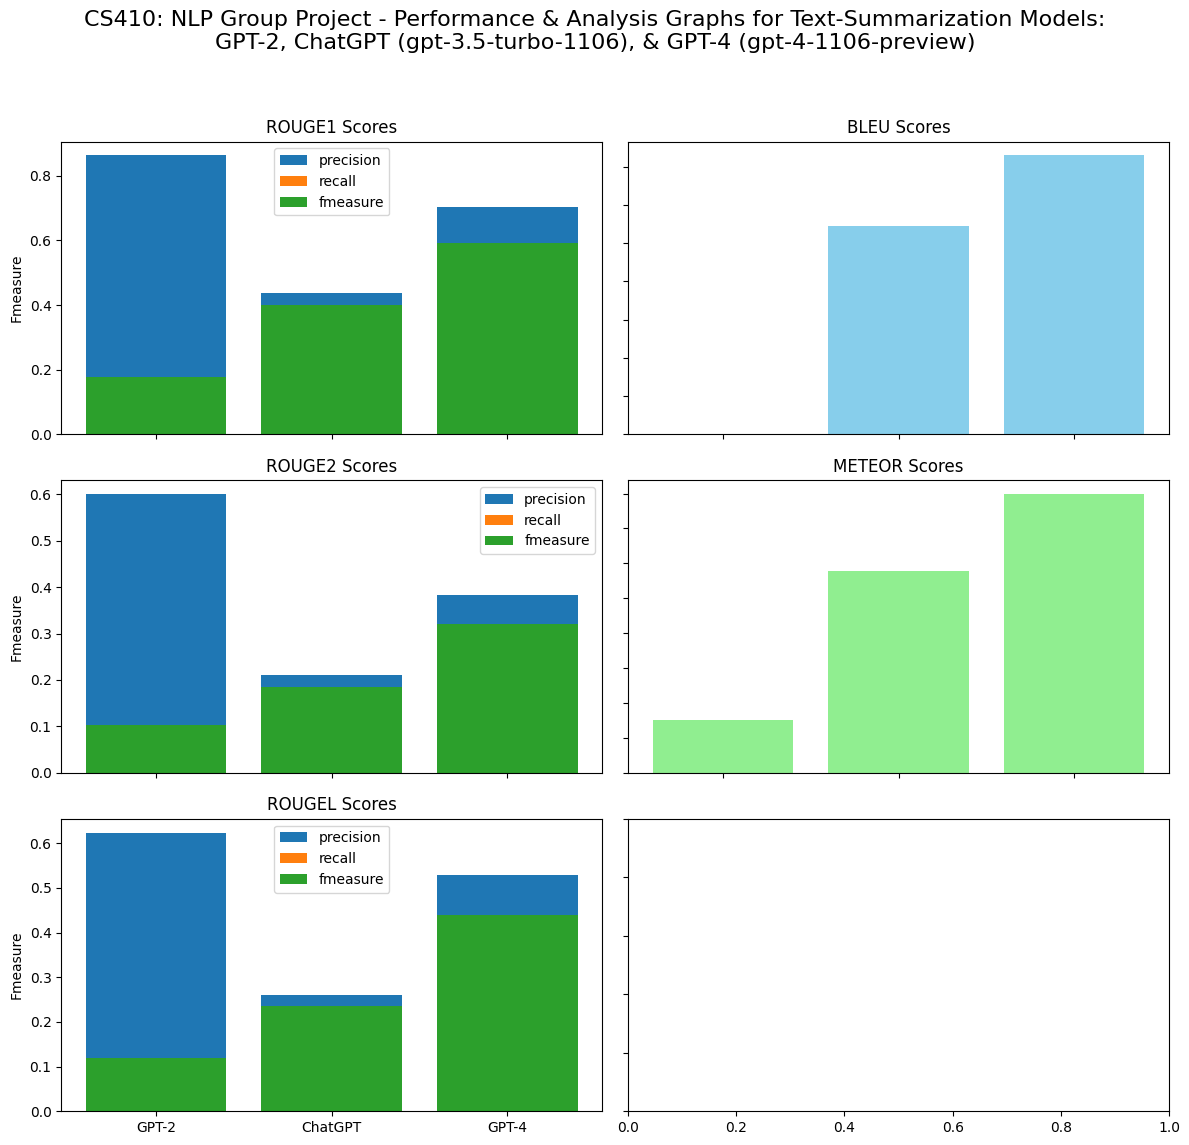

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for each model
models_data = {
    'GPT-2': {
        'ROUGE': {
            'rouge1': {'precision': 0.8633, 'recall': 0.1160, 'fmeasure': 0.1765},
            'rouge2': {'precision': 0.6010, 'recall': 0.0624, 'fmeasure': 0.1035},
            'rougeL': {'precision': 0.6240, 'recall': 0.0760, 'fmeasure': 0.1199}
        },
        'BLEU': 8.47e-06,
        'METEOR': 0.0755
    },
    'ChatGPT': {
        'ROUGE': {
            'rouge1': {'precision': 0.4381, 'recall': 0.3920, 'fmeasure': 0.3992},
            'rouge2': {'precision': 0.2114, 'recall': 0.1795, 'fmeasure': 0.1853},
            'rougeL': {'precision': 0.2609, 'recall': 0.2292, 'fmeasure': 0.2346}
        },
        'BLEU': 0.1365,
        'METEOR': 0.2896
    },
    'GPT-4': {
        'ROUGE': {
            'rouge1': {'precision': 0.7034, 'recall': 0.5178, 'fmeasure': 0.5925},
            'rouge2': {'precision': 0.3843, 'recall': 0.2804, 'fmeasure': 0.3216},
            'rougeL': {'precision': 0.5290, 'recall': 0.3794, 'fmeasure': 0.4390}
        },
        'BLEU': 0.1823,
        'METEOR': 0.3993
    }
}

# Define metric names and models
metrics = ['precision', 'recall', 'fmeasure', 'BLEU', 'METEOR']
models = ['GPT-2', 'ChatGPT', 'GPT-4']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('CS410: NLP Group Project - Performance & Analysis Graphs for Text-Summarization Models:\nGPT-2, ChatGPT (gpt-3.5-turbo-1106), & GPT-4 (gpt-4-1106-preview)', fontsize=16)

for i, rouge_metric in enumerate(['rouge1', 'rouge2', 'rougeL']):
    for j, metric in enumerate(['precision', 'recall', 'fmeasure']):
        values = [models_data[model]['ROUGE'][rouge_metric][metric] for model in models]
        axs[i][0].bar(models, values, label=metric)
        axs[i][0].set_title(f"{rouge_metric.upper()} Scores")
        axs[i][0].set_ylabel(metric.capitalize())
        axs[i][0].legend()

# Plot BLEU and METEOR scores
bleu_scores = [models_data[model]['BLEU'] for model in models]
meteor_scores = [models_data[model]['METEOR'] for model in models]

axs[0][1].bar(models, bleu_scores, color='skyblue')
axs[0][1].set_title('BLEU Scores')
axs[0][1].set_ylabel('Score')

axs[1][1].bar(models, meteor_scores, color='lightgreen')
axs[1][1].set_title('METEOR Scores')
axs[1][1].set_ylabel('Score')

# Hide the empty subplot (if any)
for ax in axs.flatten():
    ax.label_outer()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

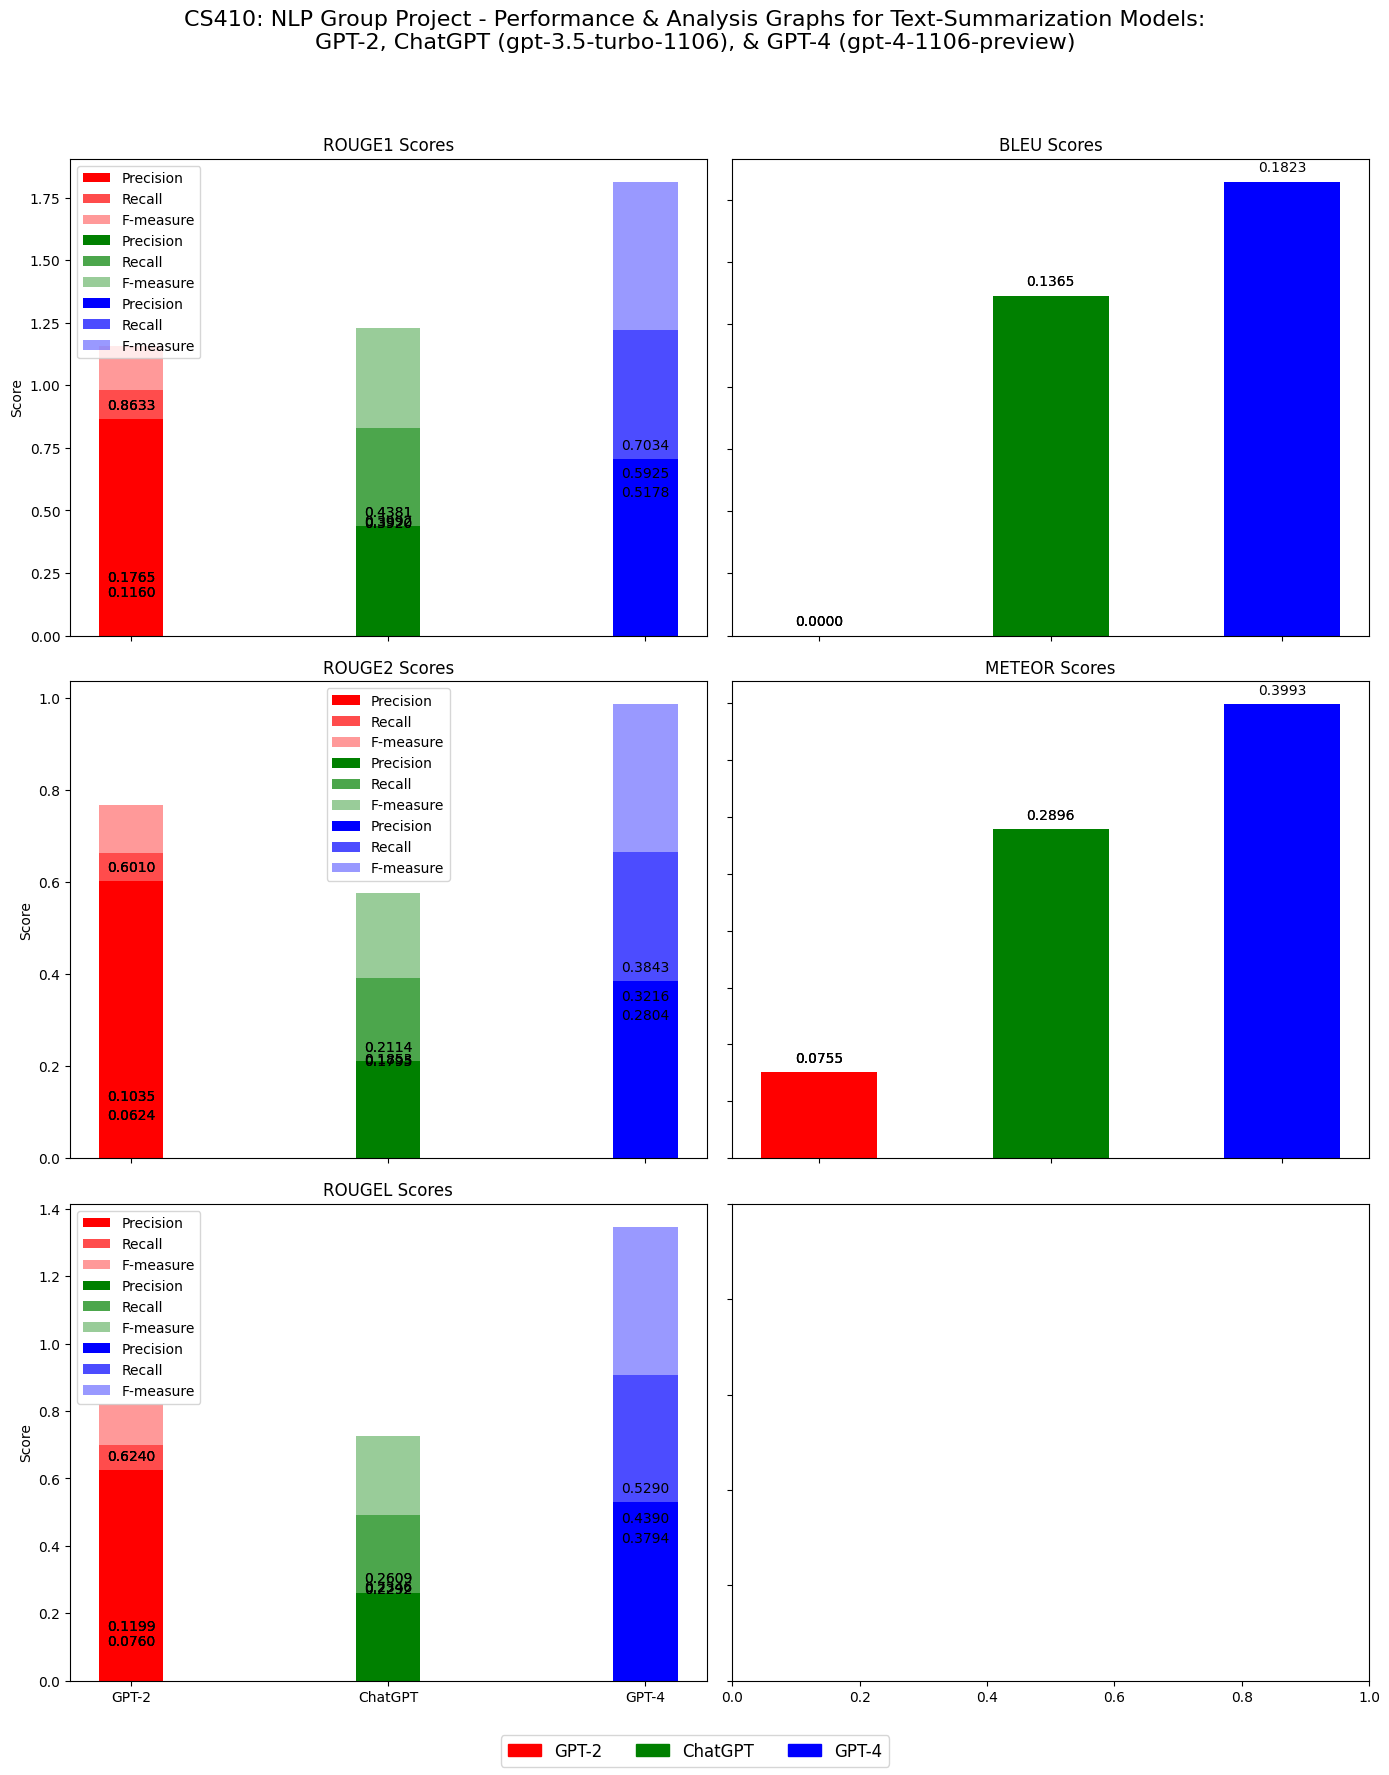

In [53]:
import matplotlib.pyplot as plt

# Define the data for each model
models_data = {
    'GPT-2': {
        'ROUGE': {
            'rouge1': {'precision': 0.8633, 'recall': 0.1160, 'fmeasure': 0.1765},
            'rouge2': {'precision': 0.6010, 'recall': 0.0624, 'fmeasure': 0.1035},
            'rougeL': {'precision': 0.6240, 'recall': 0.0760, 'fmeasure': 0.1199}
        },
        'BLEU': 8.47e-06,
        'METEOR': 0.0755
    },
    'ChatGPT': {
        'ROUGE': {
            'rouge1': {'precision': 0.4381, 'recall': 0.3920, 'fmeasure': 0.3992},
            'rouge2': {'precision': 0.2114, 'recall': 0.1795, 'fmeasure': 0.1853},
            'rougeL': {'precision': 0.2609, 'recall': 0.2292, 'fmeasure': 0.2346}
        },
        'BLEU': 0.1365,
        'METEOR': 0.2896
    },
    'GPT-4': {
        'ROUGE': {
            'rouge1': {'precision': 0.7034, 'recall': 0.5178, 'fmeasure': 0.5925},
            'rouge2': {'precision': 0.3843, 'recall': 0.2804, 'fmeasure': 0.3216},
            'rougeL': {'precision': 0.5290, 'recall': 0.3794, 'fmeasure': 0.4390}
        },
        'BLEU': 0.1823,
        'METEOR': 0.3993
    }
}

# Define metric names and models
models = ['GPT-2', 'ChatGPT', 'GPT-4']
colors = ['red', 'green', 'blue']  # Colors for each model

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('CS410: NLP Group Project - Performance & Analysis Graphs for Text-Summarization Models:\nGPT-2, ChatGPT (gpt-3.5-turbo-1106), & GPT-4 (gpt-4-1106-preview)', fontsize=16)

# Define a function to add text labels above the bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.4f}".format(y_value)
        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va=va)

# Plot ROUGE scores
for i, rouge_metric in enumerate(['rouge1', 'rouge2', 'rougeL']):
    for j, (model, color) in enumerate(zip(models, colors)):
        values = models_data[model]['ROUGE'][rouge_metric]
        axs[i][0].bar(model, values['precision'], label='Precision', color=color, width=0.25, align='center')
        axs[i][0].bar(model, values['recall'], bottom=values['precision'], label='Recall', color=color, alpha=0.7, width=0.25, align='center')
        axs[i][0].bar(model, values['fmeasure'], bottom=values['precision']+values['recall'], label='F-measure', color=color, alpha=0.4, width=0.25, align='center')
        add_value_labels(axs[i][0])
    axs[i][0].set_title(f"{rouge_metric.upper()} Scores")
    axs[i][0].set_ylabel('Score')
    axs[i][0].legend()

# Plot BLEU and METEOR scores
for i, score_type in enumerate(['BLEU', 'METEOR']):
    for j, (model, color) in enumerate(zip(models, colors)):
        score = models_data[model][score_type]
        axs[i][1].bar(model, score, color=color, label=model, width=0.5)
        add_value_labels(axs[i][1])
    axs[i][1].set_title(f'{score_type} Scores')
    axs[i][1].set_ylabel('Score')

# Hide the empty subplot (if any)
for ax in axs.flatten():
    ax.label_outer()

# Create legend for color keys
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = models
fig.legend(handles, labels, loc='lower center', ncol=len(models), fontsize='large')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **References**

#### Libraries & Dependencies
    numpy
    pandas
    torch
    random
    matplotlib

[HuggingFace_hub](https://huggingface.co/docs/hub/models-libraries)

[*OpenAI*](https://openai.com/research/better-language-models)'s Lineage of [*```GPT Models```*](https://platform.openai.com/docs/models/) ((*Generative Pretrained Transformer*): )[*```GPT-2```*](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), [*```ChatGPT```*](https://chat.openai.com/) {[*```gpt-3.5-turbo-1106```*](https://arxiv.org/abs/2005.14165)}, & [*```GPT-4```*](https://cdn.openai.com/papers/GPTV_System_Card.pdf) {[*```gpt-4-1106-preview```*](https://openai.com/blog/new-models-and-developer-products-announced-at-devday)}

[*HuggingFace*](https://huggingface.co/docs/hub/models-libraries)'s [*transformers*](https://huggingface.co/docs/transformers/index)

```from``` [```transformers```](https://huggingface.co/docs/transformers/index) ```import``` [```AutoModel```](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html)(s)

```from``` [```transformers```](https://huggingface.co/docs/transformers/index) ```import``` [```AutoTokenizer```](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer)

```from``` [```transformers```](https://huggingface.co/docs/transformers/index) ```import``` [```AutoTokenizer.from_pretrained```](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#transformers.AutoTokenizer.from_pretrained), [```AutoModel.from_pretrained```](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#transformers.AutoModelForPreTraining.from_pretrained)

```from``` [```transformers```](https://huggingface.co/docs/transformers/) ```import``` [*```GPT-2```*](https://github.com/openai/gpt-2/) {model}

```from``` [```transformers```](https://huggingface.co/docs/transformers/) ```import``` [*```GPT2LMHeadModel```*](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel/)

```from``` [```transformers```](https://huggingface.co/docs/transformers/) ```import``` [*```GPT2Tokenizer```*](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer)

[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

[sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

[sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

[sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

[nbconvert](https://nbconvert.readthedocs.io/en/latest/)


#### References & Credits

[*OpenAI*](https://platform.openai.com/docs/models/)

[***```ChatGPT```***](https://openai.com/blog/chatgpt)

[***```gpt-3.5-turbo-1106```***](https://openai.com/blog/new-models-and-developer-products-announced-at-devday)

[*A Brief History of Prompt: Leveraging Language Models*](https://arxiv.org/abs/2310.04438)

[*HuggingFace*](https://huggingface.co/)

[```transformers```](https://huggingface.co/docs/transformers/index)

["*Language Models are Few-Shot Learners*"](https://arxiv.org/abs/2005.14165)

[*Language Models are Unsupervised Multitask Learners* by Alec Radford, Jeffrey Wu, Rewon Child David Luan, Dario Amodei, & Ilya Sutskever (*OpenAI*; February 14th, 2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

[*Comparing BERT, GPT-2, and GPT-3: A Look at the Pros and Cons of Popular Pre-Trained Language Models* by Em Fhal (January 17th, 2023)](https://medium.com/codepubcast/comparing-bert-gpt-2-and-gpt-3-a-look-at-the-pros-and-cons-of-popular-pre-trained-language-1e32c6f0af9b)

#### Credits & Acknowledgement

Credits to GitHub Copilot & ChatGPT for code implementation assistance.